In [1]:
!pip install torch==1.11.0  # version recommended by source
!pip install git+https://github.com/gretelai/gretel-synthetics.git

You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.
  Cloning https://github.com/gretelai/gretel-synthetics.git to /tmp/pip-req-build-tskoodq2
  Running command git clone --filter=blob:none -q https://github.com/gretelai/gretel-synthetics.git /tmp/pip-req-build-tskoodq2
  Resolved https://github.com/gretelai/gretel-synthetics.git to commit 2ed9d31ce8f56afd1519c38859ab081e8cdef579
  Preparing metadata (setup.py) ... done
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md
from sklearn.preprocessing import MinMaxScaler
from pickle import dump, load
from skimage.util.shape import view_as_windows
import time

import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

In [4]:
# set up DGAN config.

config = DGANConfig(
    max_sequence_len=100,
    sample_len=20,  # trying a larger sample_len
    batch_size=min(1000, 51),
    apply_feature_scaling=True,
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000,
)

model = DGAN(config)

In [7]:
# loading model for future use
model = model.load("../models/dgan_casing.pt")

In [8]:
# Generate synthetic data - this ran near instantly
_, synthetic_features = model.generate_numpy(1000)

In [11]:
def plot_100_slice(slice, ind):
    plt.plot(slice, label="pressure")
    ax = plt.gca()
    ax.title.set_text("Slice" + str(ind))
    plt.legend(prop={"size": 9})

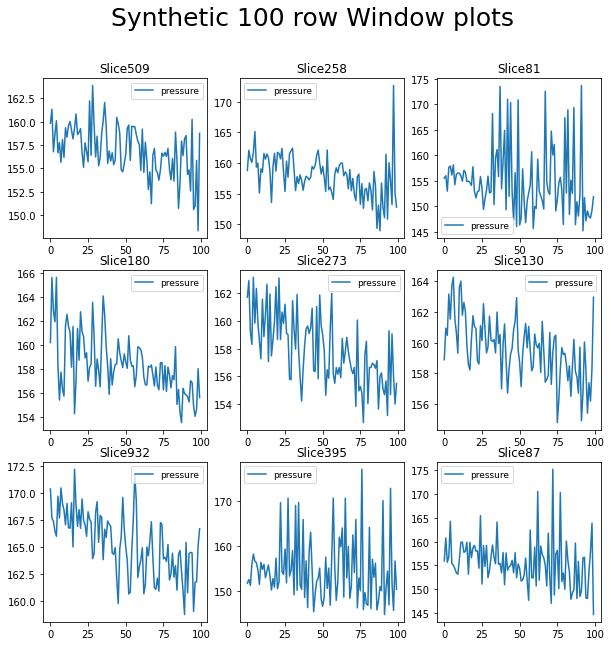

In [12]:
# plot random synthetic windows

figure = plt.figure(figsize=(10, 10))
figure.suptitle("Synthetic 100 row Window plots", fontsize=25, fontweight="roman")

for i in range(9):
    figure.add_subplot(3, 3, i + 1)
    index = np.random.choice(1000)
    sl = synthetic_features[index]
    plot_100_slice(sl, index)

plt.show()

In [13]:
synthetic_features.shape

(1000, 100, 1)

In [14]:
reshaped_data = np.empty((100000, 2))

In [22]:
init = 0
# outer loop around samples
for x in range(1000):
    # loop of each sample
    for y in range(100):
        reshaped_data[init][0] = x + 1000
        reshaped_data[init][1] = synthetic_features[x, y, 0]
        init += 1

In [23]:
reshaped_data

array([[1000.        ,  155.53825378],
       [1000.        ,  159.20999146],
       [1000.        ,  157.08752441],
       ...,
       [1999.        ,  145.47966003],
       [1999.        ,  163.73794556],
       [1999.        ,  146.52256775]])

In [26]:
reshaped_df = pd.DataFrame(reshaped_data, columns=["id", "pressure"])

In [27]:
reshaped_df

,id,pressure
0,1000.0,155.538254
1,1000.0,159.209991
2,1000.0,157.087524
3,1000.0,161.204391
4,1000.0,160.599869
...,...,...
99995,1999.0,156.044479
99996,1999.0,146.370514
99997,1999.0,145.479660
99998,1999.0,163.737946


In [29]:
reshaped_df.to_csv("../data/gasPump/synthetic_casing.csv", index=None)